# Recipe QA Chatbot: Multi-Experiment Optimization

This notebook optimizes a T5-based recipe QA chatbot through four distinct experiments, each testing different hyperparameters, data preprocessing, or generation settings. Utility functions and experiments are separated into individual cells for clarity, modularity, and ease of explanation. The notebook includes:
- Isolated utility functions for data processing, training, and evaluation.
- Four experiments run sequentially with clear outputs.
- Visualizations of training metrics and experiment comparisons.
- Comprehensive logging and step-by-step result display.
- Interactive testing with the best model.

**Dataset**: `recipe_qa_dataset.json` (~2476 train, 310 validation, 310 test samples).  
**Model**: `t5-base`.  
**Environment**: M1/M2 Mac, CPU-only.  
**Date**: June 21, 2025, 11:47 PM CAT.

## 1. Setup and Imports

Configure the environment for CPU-only execution and import required libraries. Results are displayed to confirm setup completion.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_LOGGING_VERBOSITY'] = 'ERROR'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.ERROR)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import T5Tokenizer, TFT5ForConditionalGeneration, AdamWeightDecay
from sklearn.model_selection import train_test_split
import json
import time
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from datetime import datetime

nltk.download('punkt_tab', quiet=True)
nltk.download('punkt', quiet=True)

# Verify CPU-only execution
if tf.config.list_physical_devices('GPU'):
    print('Warning: GPUs detected but disabled.')
else:
    print('Running on CPU only.')

tf.config.set_soft_device_placement(True)
tf.config.experimental.set_visible_devices([], 'GPU')
tf.config.optimizer.set_jit(False)

# Create directories for logs and experiments
os.makedirs('logs', exist_ok=True)
os.makedirs('experiments', exist_ok=True)
non_recipe_log = 'logs/non_recipe_questions.txt'
generation_error_log = 'logs/generation_errors.txt'
low_bleu_log = 'logs/low_bleu.txt'
results_log = 'logs/experiment_results.json'

print('Setup completed successfully. Log directories initialized.')


/Users/samenergy/.pyenv/versions/3.9.6/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup completed successfully. Log directories initialized.


## 2. Detect Recipe Domain

**Purpose**: Identifies if a question is recipe-related based on keywords and patterns. Non-recipe questions are logged and filtered out.

**Inputs**: `question` (str) - The input question.
**Outputs**: `bool` - True if recipe-related, False otherwise.
**Usage**: Called during data preparation and answer generation to ensure domain relevance.

In [2]:
def detect_recipe_domain(question: str) -> bool:
    question_lower = question.lower().strip()
    if not re.match(r'^[a-zA-Z0-9\s.,!?()\'\-\°\/:&\+\%]+$', question_lower):
        with open(non_recipe_log, 'a') as f:
            f.write(f'{datetime.now().isoformat()} - Invalid question: {question}\n')
        return False
    recipe_keywords = [
        'cook', 'recipe', 'ingredient', 'serving', 'bake', 'fry', 'boil', 'grill', 'roast',
        'prep', 'prepare', 'time', 'dish', 'food', 'cuisine', 'dessert', 'appetizer',
        'main', 'side', 'breakfast', 'lunch', 'dinner', 'snack', 'oven', 'stove', 'pan',
        'pot', 'mix', 'chop', 'slice', 'season', 'taste', 'flavor', 'sauce', 'soup', 'salad',
        'rating', 'calories', 'calorie', 'nutrition', 'nutritional', 'serves', 'yield'
    ]
    recipe_patterns = [
        r'\bhow\b.*\b(cook|make|prepare|bake|recipe|calories|calorie|nutrition|serving)\b',
        r'\bwhat\b.*\b(ingredient|dish|recipe|rating|calories|calorie|nutrition|serving)\b',
        r'\bhow\b.*\b(long|time|many)\b.*\b(serving|prep|cook|calories|calorie|nutrition)\b',
        r'\b(ingredient|step|method|rating|calories|calorie|nutrition)\b.*\b(recipe|dish)\b'
    ]
    if any(keyword in question_lower for keyword in recipe_keywords) or \
       any(re.search(pattern, question_lower) for pattern in recipe_patterns):
        return True
    with open(non_recipe_log, 'a') as f:
        f.write(f'{datetime.now().isoformat()} - Non-recipe: {question}\n')
    return False

# Test domain detection
test_questions = [
    'How long to cook pasta?',
    'What is the rating of Restaurant-Style Buffalo Chicken Wings?',
    'How many calories are in Miso Soup?',
    'What is the greenhouse effect?'
]
print('Testing domain detection:')
for q in test_questions:
    result = detect_recipe_domain(q)
    print(f'  {q}: {"Recipe" if result else "Non-Recipe"}')
print('Domain detection test completed.')


Testing domain detection:
  How long to cook pasta?: Recipe
  What is the rating of Restaurant-Style Buffalo Chicken Wings?: Recipe
  How many calories are in Miso Soup?: Recipe
  What is the greenhouse effect?: Non-Recipe
Domain detection test completed.


## 3. Clean Text

**Purpose**: Cleans input text by removing invalid characters and normalizing whitespace.

**Inputs**: `text` (str) - The text to clean.
**Outputs**: `str` - Cleaned text.
**Usage**: Applied to questions and answers during data preparation.

In [3]:
def clean_text(text: str) -> str:
    text = text.strip()
    text = re.sub(r'[^a-zA-Z0-9\s.,!?()\'\-\°\/:&\+\%]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text


## 4. Paraphrase Question

**Purpose**: Generates paraphrased versions of questions for data augmentation in specific experiments.

**Inputs**: `question` (str) - The original question.
**Outputs**: `list` - List of original and paraphrased questions.
**Usage**: Used in Experiment 2 to increase dataset diversity.

In [4]:
def paraphrase_question(question: str) -> list:
    question_lower = question.lower()
    paraphrases = [question]
    if 'how many calories' in question_lower:
        paraphrases.append(question_lower.replace('how many calories', 'what is the calorie count').capitalize() + '?')
    elif 'how long' in question_lower:
        paraphrases.append(question_lower.replace('how long', 'what is the preparation time for').capitalize() + '?')
    elif 'what is the rating' in question_lower:
        paraphrases.append(question_lower.replace('what is the rating', 'how is').capitalize() + ' rated?')
    return paraphrases


## 5. Prepare Data

**Purpose**: Loads, filters, and splits the dataset into train, validation, and test sets, applying experiment-specific preprocessing.

**Inputs**: `experiment_id` (str) - The experiment identifier.
**Outputs**: `tuple` - Train, validation, and test DataFrames.
**Usage**: Called by each experiment to prepare its dataset.

In [5]:
def prepare_data(experiment_id: str):
    print(f'{experiment_id} - Loading dataset...')
    try:
        with open('recipe_qa_dataset.json', 'r') as f:
            data = json.load(f)
        print(f'{experiment_id} - Dataset loaded successfully. Total recipes: {len(data)}')
    except FileNotFoundError:
        print(f'{experiment_id} - Error: recipe_qa_dataset.json not found.')
        raise

    qa_list = []
    max_calories = 500 if experiment_id in ['exp2', 'exp4'] else 1000
    for recipe in data:
        for qa in recipe['qa_pairs']:
            question = clean_text(qa['question'])
            answer = clean_text(qa['answer'])
            calorie_match = re.search(r'(\d+\.?\d*)\s*calories', answer, re.IGNORECASE)
            if calorie_match and float(calorie_match.group(1)) > max_calories:
                continue
            time_match = re.search(r'(\d+)\s*(hour|hr|minute|min)', answer, re.IGNORECASE)
            if time_match:
                time_val = int(time_match.group(1))
                unit = time_match.group(2).lower()
                if (unit.startswith('h') and time_val > 4) or (unit.startswith('m') and time_val > 240):
                    continue
            if question and answer and detect_recipe_domain(question):
                questions = paraphrase_question(question) if experiment_id == 'exp2' else [question]
                for q in questions:
                    qa_list.append({'question': q, 'answer': answer})

    print(f'{experiment_id} - Total QA pairs after filtering: {len(qa_list)}')
    df = pd.DataFrame(qa_list)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    os.makedirs(f'experiments/{experiment_id}', exist_ok=True)
    train_df.to_csv(f'experiments/{experiment_id}/train_qa.csv', index=False)
    val_df.to_csv(f'experiments/{experiment_id}/val_qa.csv', index=False)
    test_df.to_csv(f'experiments/{experiment_id}/test_qa.csv', index=False)

    print(f'{experiment_id} - Splits completed:')
    print(f'  Train: {len(train_df)} samples')
    print(f'  Validation: {len(val_df)} samples')
    print(f'  Test: {len(test_df)} samples')

    return train_df, val_df, test_df


## 6. Preprocess Function

**Purpose**: Tokenizes questions and answers for model input, applying experiment-specific configurations.

**Inputs**: `df` (DataFrame) - Dataset to preprocess; `tokenizer` (T5Tokenizer) - Model tokenizer; `config` (dict) - Experiment configuration; `experiment_id` (str) - Experiment identifier.
**Outputs**: `dict` - Tokenized inputs with input IDs, attention masks, and labels.
**Usage**: Called during training to prepare datasets.

In [6]:
def preprocess_function(df, tokenizer, config, experiment_id):
    print(f'{experiment_id} - Preprocessing data...')
    questions = df['question'].tolist()
    answers = df['answer'].tolist()
    clean_questions = []
    clean_answers = []
    for q, a in zip(questions, answers):
        q_clean = q.strip()
        if not q_clean.endswith('?'):
            q_clean += '?'
        a_clean = a.strip()
        if len(a_clean.split('. ')) > 2:
            a_clean = '. '.join(a_clean.split('. ')[:2]) + '.'
        clean_questions.append(f'question: {q_clean}')
        clean_answers.append(a_clean)
    model_inputs = tokenizer(
        clean_questions,
        max_length=config['max_input_length'],
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    labels = tokenizer(
        clean_answers,
        max_length=config['max_target_length'],
        truncation=True,
        padding='max_length',
        return_tensors='tf'
    )
    model_inputs['labels'] = labels['input_ids']
    print(f'{experiment_id} - Preprocessing completed. Input shapes: {model_inputs["input_ids"].shape}')
    return model_inputs


## 7. Train Model

**Purpose**: Trains the T5 model using the specified configuration and datasets, with early stopping for some experiments.

**Inputs**: `config` (dict) - Experiment configuration; `train_df` (DataFrame) - Training data; `val_df` (DataFrame) - Validation data; `experiment_id` (str) - Experiment identifier.
**Outputs**: `tuple` - Trained model, tokenizer, final train loss, final validation loss, training time, and history.
**Usage**: Called by each experiment to train the model.

In [7]:
import matplotlib.pyplot as plt
def train_model(config, train_df, val_df, experiment_id):
    print(f'\n=== {experiment_id} Training ===')
    print(f'{experiment_id} - Training Configuration:')
    for key, value in config.items():
        print(f'  {key}: {value}')

    print(f'{experiment_id} - Loading {config["model_name"]}...')
    try:
        tokenizer = T5Tokenizer.from_pretrained(config['model_name'], legacy=False)
        model = TFT5ForConditionalGeneration.from_pretrained(config['model_name'])
        print(f'{experiment_id} - Model and tokenizer loaded successfully.')
    except Exception as e:
        print(f'{experiment_id} - Failed to load model: {str(e)}')
        raise

    train_inputs = preprocess_function(train_df, tokenizer, config, experiment_id)
    val_inputs = preprocess_function(val_df, tokenizer, config, experiment_id)

    train_dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': train_inputs['input_ids'],
        'attention_mask': train_inputs['attention_mask'],
        'labels': train_inputs['labels']
    }).batch(config['batch_size']).shuffle(1000)
    val_dataset = tf.data.Dataset.from_tensor_slices({
        'input_ids': val_inputs['input_ids'],
        'attention_mask': val_inputs['attention_mask'],
        'labels': val_inputs['labels']
    }).batch(config['batch_size'])

    optimizer = AdamWeightDecay(
        learning_rate=config['learning_rate'],
        weight_decay_rate=config['weight_decay']
    )
    model.compile(optimizer=optimizer)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ] if experiment_id in ['exp1', 'exp3', 'exp4'] else []

    print(f'{experiment_id} - Starting training...')
    start_time = datetime.now()
    try:
        with tf.device('/CPU:0'):
            history = model.fit(
                train_dataset,
                validation_data=val_dataset,
                epochs=config['num_epochs'],
                verbose=1,
                callbacks=callbacks
            )
    except Exception as e:
        print(f'{experiment_id} - Training failed: {str(e)}')
        raise

    training_time = datetime.now() - start_time
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f'\n{experiment_id} - Training Results:')
    print(f'  Final Train Loss: {final_train_loss:.4f}')
    print(f'  Final Val Loss: {final_val_loss:.4f}')
    print(f'  Training Time: {training_time}')

    import matplotlib.pyplot as plt

    epochs = range(1, len(history.history['loss']) + 1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{experiment_id} - Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Save model and tokenizer
    save_path = f'experiments/{experiment_id}'
    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)
    print(f'{experiment_id} - Model saved to {save_path}')

    return model, tokenizer, final_train_loss, final_val_loss, training_time, history.history


## 8. Generate Answer Optimized

**Purpose**: Generates answers for input questions using the trained model, with domain checking and error handling.

**Inputs**: `question` (str) - Input question; `model` (TFT5ForConditionalGeneration) - Trained model; `tokenizer` (T5Tokenizer) - Model tokenizer; `config` (dict) - Experiment configuration; `experiment_id` (str) - Experiment identifier; `max_length` (int) - Maximum output length.
**Outputs**: `tuple` - Generated answer and raw answer (or error message and None).
**Usage**: Used during evaluation and interactive testing.

In [8]:
def generate_answer_optimized(question: str, model, tokenizer, config, experiment_id: str, max_length: int = 80) -> tuple:
    print(f'{experiment_id} - Generating answer for: {question}')
    if not detect_recipe_domain(question):
        print(f'{experiment_id} - Non-recipe question detected.')
        return 'Sorry, I can only answer recipe-related questions.', None
    try:
        with tf.device('/CPU:0'):
            input_text = f'question: {question.strip()}'
            input_ids = tokenizer.encode(
                input_text,
                return_tensors='tf',
                max_length=config['max_input_length'],
                truncation=True
            )
            outputs = model.generate(
                input_ids,
                max_length=max_length,
                temperature=config.get('temperature', 0.1),
                do_sample=True,
                num_beams=config.get('num_beams', 10),
                no_repeat_ngram_size=3,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id
            )
            raw_answer = tokenizer.decode(outputs[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)
            if not re.match(r'^[a-zA-Z0-9\s.,!?()\'\-\°\/:&\+\%]+$', raw_answer):
                with open(generation_error_log, 'a') as f:
                    f.write(f'{datetime.now().isoformat()} - {experiment_id} - Non-English: {question} -> {raw_answer}\n')
                print(f'{experiment_id} - Non-English output detected.')
                return 'Error: Non-English output detected.', raw_answer
            answer = post_process_factual(raw_answer, question, experiment_id)
            print(f'{experiment_id} - Generated Answer: {answer[:100]}...')
            return answer, raw_answer
    except Exception as e:
        with open(generation_error_log, 'a') as f:
            f.write(f'{datetime.now().isoformat()} - {experiment_id} - Error: {question} -> {str(e)}\n')
        print(f'{experiment_id} - Error generating answer: {str(e)}')
        return f'Error generating answer: {str(e)}', None


## 9. Post Process Factual

**Purpose**: Post-processes generated answers to fix factual errors and clean up formatting.

**Inputs**: `answer` (str) - Generated answer; `question` (str) - Input question; `experiment_id` (str) - Experiment identifier.
**Outputs**: `str` - Processed answer.
**Usage**: Called by `generate_answer_optimized` to ensure factual accuracy.

In [9]:
def post_process_factual(answer: str, question: str, experiment_id: str) -> str:
    if answer.lower().startswith(question.lower()):
        answer = answer[len(question):].strip()
    for prefix in ['question:', 'answer:', 'response:', 'a:', 'q:']:
        if answer.lower().startswith(prefix):
            answer = answer[len(prefix):].strip()
    factual_fixes = {
        'bake at 200': 'bake at 350',
        'fry in water': 'fry in oil',
        'serves 0': 'serves a specific number',
        'prep in seconds': 'prep in minutes',
        'cook for days': 'cook for hours or minutes'
    }
    for error, correction in factual_fixes.items():
        answer = re.sub(re.escape(error), correction, answer, flags=re.IGNORECASE)
    calorie_match = re.search(r'(\d+\.?\d*)\s*calories', answer, re.IGNORECASE)
    if calorie_match:
        calories = float(calorie_match.group(1))
        max_calories = 500 if experiment_id in ['exp2', 'exp4'] else 1000
        dish_ranges = {
            'soup': (20, 200),
            'salad': (50, 300),
            'dessert': (100, 500),
            'main': (200, 500)
        } if experiment_id == 'exp4' else {}
        for dish_type, (min_cal, max_cal) in dish_ranges.items():
            if dish_type in question.lower() and not (min_cal <= calories <= max_cal):
                answer = answer.replace(calorie_match.group(0), 'a specific calorie count')
                break
        else:
            if not (10 <= calories <= max_calories):
                answer = answer.replace(calorie_match.group(0), 'a specific calorie count')
    time_match = re.search(r'(\d+)\s*(hour|hr|minute|min)', answer, re.IGNORECASE)
    if time_match:
        time_val = int(time_match.group(1))
        unit = time_match.group(2).lower()
        if (unit.startswith('h') and time_val > 4) or (unit.startswith('m') and time_val > 60 and 'prep' in question.lower()):
            answer = re.sub(r'\d+\s*(hour|hr|minute|min)', 'a reasonable time', answer, flags=re.IGNORECASE)
    words = answer.split()
    cleaned_words = [words[0]] if words else []
    for i in range(1, len(words)):
        if words[i].lower() != words[i-1].lower():
            cleaned_words.append(words[i])
    answer = ' '.join(cleaned_words)
    return answer if len(answer.split()) >= 5 else 'Please provide more details about the recipe question.'


## 10. Check Factual Errors

**Purpose**: Identifies factual errors in generated answers, such as incorrect cooking methods or unrealistic calorie counts.

**Inputs**: `answer` (str) - Generated answer; `question` (str) - Input question; `expected_answer` (str, optional) - Ground truth answer; `experiment_id` (str) - Experiment identifier.
**Outputs**: `list` - List of error types detected.
**Usage**: Used during evaluation to quantify factual inaccuracies.

In [10]:
def check_factual_errors(answer: str, question: str, expected_answer: str = None, experiment_id: str = '') -> list:
    if answer.startswith('Sorry') or answer.startswith('Error'):
        return ['non_recipe_or_error']
    errors = []
    answer_lower = answer.lower()
    error_patterns = {
        'cooking_method_error': ['fry in water', 'bake in microwave', 'boil in oven'],
        'time_error': ['cook for days', 'prep in seconds', 'bake for years'],
        'servings_error': ['serves 0', 'yields zero', 'serves no one'],
        'ingredient_error': ['sugar in savory', 'salt in dessert', 'water as main ingredient']
    }
    for error_type, patterns in error_patterns.items():
        for pattern in patterns:
            if pattern in answer_lower:
                errors.append(error_type)
    tolerance = 0.05 if experiment_id == 'exp4' else 0.1
    if 'calories' in question.lower():
        calorie_match = re.search(r'(\d+\.?\d*)\s*calories', answer_lower)
        if calorie_match:
            calories = float(calorie_match.group(1))
            max_calories = 500 if experiment_id in ['exp2', 'exp4'] else 1000
            dish_ranges = {
                'soup': (20, 200),
                'salad': (50, 300),
                'dessert': (100, 500),
                'main': (200, 500)
            } if experiment_id == 'exp4' else {}
            for dish_type, (min_cal, max_cal) in dish_ranges.items():
                if dish_type in question.lower() and not (min_cal <= calories <= max_cal):
                    errors.append('calorie_range_error')
                    break
            else:
                if not (10 <= calories <= max_calories):
                    errors.append('calorie_range_error')
            if expected_answer:
                expected_calorie = re.search(r'(\d+\.?\d*)\s*calories', expected_answer.lower())
                if expected_calorie:
                    expected_val = float(expected_calorie.group(1))
                    if abs(calories - expected_val) / expected_val > tolerance:
                        errors.append('calorie_mismatch_error')
        else:
            errors.append('missing_calorie_info')
    if 'rating' in question.lower():
        rating_match = re.search(r'(\d+\.?\d*)\s*(?:based on|out of)', answer_lower)
        if rating_match and expected_answer:
            rating = float(rating_match.group(1))
            expected_rating = re.search(r'(\d+\.?\d*)\s*(?:based on|out of)', expected_answer.lower())
            if expected_rating:
                expected_val = float(expected_rating.group(1))
                if abs(rating - expected_val) > tolerance:
                    errors.append('rating_mismatch_error')
    if 'time' in question.lower():
        time_match = re.search(r'(\d+)\s*(hour|hr|minute|min)', answer_lower)
        if time_match and expected_answer:
            time_val = int(time_match.group(1))
            unit = time_match.group(2).lower()
            expected_time = re.search(r'(\d+)\s*(hour|hr|minute|min)', expected_answer.lower())
            if expected_time:
                exp_time_val = int(expected_time.group(1))
                exp_unit = expected_time.group(2).lower()
                if unit == exp_unit and abs(time_val - exp_time_val) / exp_time_val > 0.2:
                    errors.append('time_mismatch_error')
    words = answer_lower.split()
    for i in range(len(words)-1):
        if words[i] == words[i+1]:
            errors.append('repetition_error')
            break
    return errors


## 11. Evaluate Model

**Purpose**: Evaluates the trained model on the test set, computing BLEU scores, non-English errors, and factual errors.

**Inputs**: `model` (TFT5ForConditionalGeneration) - Trained model; `tokenizer` (T5Tokenizer) - Model tokenizer; `config` (dict) - Experiment configuration; `test_df` (DataFrame) - Test data; `experiment_id` (str) - Experiment identifier.
**Outputs**: `tuple` - Average BLEU score, recipe-only BLEU score, non-English error count, factual error count, evaluation DataFrame, model, and tokenizer.
**Usage**: Called by each experiment to assess performance.

In [11]:
def evaluate_model(model, tokenizer, config, test_df, experiment_id):
    print(f'\n=== {experiment_id} Evaluation ===')
    test_questions = test_df['question'].tolist()
    test_answers = test_df['answer'].tolist()
    generated_answers = []
    raw_answers = []
    bleu_scores = []
    domain_labels = [detect_recipe_domain(q) for q in test_questions]
    recipe_bleu_scores = []
    factual_errors_list = []
    smoothing = SmoothingFunction().method1

    print(f'{experiment_id} - Calculating BLEU scores for {len(test_questions)} test samples...')
    for i, (question, expected_answer, is_recipe) in enumerate(zip(test_questions, test_answers, domain_labels)):
        try:
            if not is_recipe:
                generated_answer = 'Non-recipe question detected.'
                raw_answer = None
                bleu_scores.append(0.0)
                generated_answers.append(generated_answer)
                raw_answers.append(raw_answer)
                factual_errors_list.append(['non_recipe_or_error'])
                print(f'{experiment_id} - Warning: Sample {i+1} is non-recipe: {question}')
                continue

            generated_answer, raw_answer = generate_answer_optimized(question, model, tokenizer, config, experiment_id)
            generated_answers.append(generated_answer)
            raw_answers.append(raw_answer)
            factual_errors = check_factual_errors(generated_answer, question, expected_answer, experiment_id)
            factual_errors_list.append(factual_errors)

            if not generated_answer.startswith('Error') and not generated_answer.startswith('Sorry'):
                expected_tokens = nltk.word_tokenize(expected_answer.lower())
                generated_tokens = nltk.word_tokenize(generated_answer.lower())
                if len(generated_tokens) > 0 and len(expected_tokens) > 0:
                    bleu_score = sentence_bleu([expected_tokens], generated_tokens, smoothing_function=smoothing)
                    bleu_scores.append(bleu_score)
                    if is_recipe:
                        recipe_bleu_scores.append(bleu_score)
                    if bleu_score < 0.1:
                        with open(low_bleu_log, 'a') as f:
                            f.write(f'{datetime.now().isoformat()} - {experiment_id} - Low BLEU: {question} -> {generated_answer} (Expected: {expected_answer}, BLEU: {bleu_score:.4f})\n')
                else:
                    bleu_scores.append(0.0)
                    print(f'{experiment_id} - Warning: Empty tokens for sample {i+1}')
                    with open(generation_error_log, 'a') as f:
                        f.write(f'{datetime.now().isoformat()} - {experiment_id} - Empty tokens: {question} -> {generated_answer}\n')

                if i < 3 or bleu_score < 0.1:
                    print(f'\n{experiment_id} - Sample {i+1}:')
                    print(f'  Q: {question}')
                    print(f'  Expected: {expected_answer[:100]}...')
                    print(f'  Generated: {generated_answer[:100]}...')
                    print(f'  Raw: {raw_answer[:100] if raw_answer else "None"}...')
                    print(f'  BLEU: {bleu_score:.4f}')
                    print(f'  Factual Errors: {factual_errors}')
            else:
                bleu_scores.append(0.0)
                print(f'{experiment_id} - Error in sample {i+1}: {generated_answer}')

        except Exception as e:
            print(f'{experiment_id} - Error in sample {i+1}: {str(e)}')
            bleu_scores.append(0.0)
            generated_answers.append(f'Error: {str(e)}')
            raw_answers.append(None)
            factual_errors_list.append(['exception_error'])

        if (i + 1) % 50 == 0:
            print(f'{experiment_id} - Processed {i + 1}/{len(test_questions)} samples')

    avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
    recipe_bleu = np.mean(recipe_bleu_scores) if recipe_bleu_scores else 0.0
    non_english_errors = len([g for g in generated_answers if g.startswith('Error: Non-English')])
    factual_error_count = len([f for f in factual_errors_list if f and f != ['non_recipe_or_error']])

    print(f'\n{experiment_id} - Evaluation Summary:')
    print(f'  Average BLEU Score: {avg_bleu:.4f} (across {len(bleu_scores)} samples)')
    print(f'  Recipe-Only BLEU Score: {recipe_bleu:.4f} (across {len(recipe_bleu_scores)} recipe samples)')
    print(f'  Non-Recipe Questions Detected: {len([d for d in domain_labels if not d])}')
    print(f'  Non-English Errors: {non_english_errors}')
    print(f'  Factual Errors: {factual_error_count}')

    evaluation_df = pd.DataFrame({
        'question': test_questions,
        'expected_answer': test_answers,
        'generated_answer': generated_answers,
        'raw_answer': raw_answers,
        'bleu_score': bleu_scores,
        'is_recipe_domain': domain_labels,
        'factual_errors': factual_errors_list
    })
    evaluation_df.to_csv(f'experiments/{experiment_id}/evaluation.csv', index=False)
    print(f'{experiment_id} - Evaluation results saved to experiments/{experiment_id}/evaluation.csv')

    return avg_bleu, recipe_bleu, non_english_errors, factual_error_count, evaluation_df, model, tokenizer


## 12. Experiment Definitions

Define the configurations for the four experiments to be run individually.

In [12]:
EXPERIMENTS = {
    'exp1': {
        'model_name': 't5-base',
        'max_input_length': 128,
        'max_target_length': 256,
        'batch_size': 8,
        'learning_rate': 1e-4,
        'num_epochs': 5,
        'warmup_steps': 20,
        'weight_decay': 0.02,
        'temperature': 0.05,
        'num_beams': 12,
        'experiment_name': 'exp1_enhanced_generation'
    },
    'exp2': {
        'model_name': 't5-base',
        'max_input_length': 128,
        'max_target_length': 256,
        'batch_size': 8,
        'learning_rate': 1e-4,
        'num_epochs': 5,
        'warmup_steps': 20,
        'weight_decay': 0.02,
        'temperature': 0.1,
        'num_beams': 10,
        'experiment_name': 'exp2_data_augmentation'
    },
    'exp3': {
        'model_name': 't5-base',
        'max_input_length': 128,
        'max_target_length': 256,
        'batch_size': 4,
        'learning_rate': 3e-4,
        'num_epochs': 5,
        'warmup_steps': 20,
        'weight_decay': 0.02,
        'gradient_clip_norm': 1.0,
        'temperature': 0.1,
        'num_beams': 10,
        'experiment_name': 'exp3_hyperparameter_tuning'
    },
    'exp4': {
        'model_name': 't5-base',
        'max_input_length': 128,
        'max_target_length': 256,
        'batch_size': 6,
        'learning_rate': 2e-4,
        'num_epochs': 5,
        'warmup_steps': 20,
        'weight_decay': 0.02,
        'gradient_clip_norm': 1.0,
        'temperature': 0.05,
        'num_beams': 12,
        'experiment_name': 'exp4_hybrid'
    }
}

# Initialize results list for all experiments
results = []
best_score = -1
best_exp_id = None
best_model = None
best_tokenizer = None


## 13. Experiment 1: Enhanced Generation

**Objective**: Test a baseline configuration with enhanced generation parameters (low temperature, high num_beams) to prioritize high-quality, deterministic outputs.

**Configuration**:
- Model: `t5-base`
- Input Length: 128
- Batch Size: 8
- Learning Rate: 1e-4
- Epochs: 5
- Temperature: 0.05 (low for deterministic outputs)
- Num Beams: 12 (high for better beam search)
- Early Stopping: Enabled

**Expected Outcome**: High BLEU scores due to precise generation, but potentially limited diversity in answers.

**Utility Functions Used**: `prepare_data`, `train_model`, `evaluate_model`.


=== Starting exp1: exp1_enhanced_generation ===
exp1 - Loading dataset...
exp1 - Dataset loaded successfully. Total recipes: 344
exp1 - Total QA pairs after filtering: 3074
exp1 - Splits completed:
  Train: 2459 samples
  Validation: 307 samples
  Test: 308 samples

=== exp1 Training ===
exp1 - Training Configuration:
  model_name: t5-base
  max_input_length: 128
  max_target_length: 256
  batch_size: 8
  learning_rate: 0.0001
  num_epochs: 5
  warmup_steps: 20
  weight_decay: 0.02
  temperature: 0.05
  num_beams: 12
  experiment_name: exp1_enhanced_generation
exp1 - Loading t5-base...


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


exp1 - Model and tokenizer loaded successfully.
exp1 - Preprocessing data...
exp1 - Preprocessing completed. Input shapes: (2459, 128)
exp1 - Preprocessing data...
exp1 - Preprocessing completed. Input shapes: (307, 128)
exp1 - Starting training...
Epoch 1/5
308/308 [==============================] - 1938s 6s/step - loss: 0.5235 - val_loss: 0.1567
Epoch 2/5
308/308 [==============================] - 1703s 6s/step - loss: 0.1738 - val_loss: 0.1342
Epoch 3/5
308/308 [==============================] - 1737s 6s/step - loss: 0.1524 - val_loss: 0.1271
Epoch 4/5
308/308 [==============================] - 1758s 6s/step - loss: 0.1409 - val_loss: 0.1239
Epoch 5/5
308/308 [==============================] - 1751s 6s/step - loss: 0.1329 - val_loss: 0.1216

exp1 - Training Results:
  Final Train Loss: 0.1329
  Final Val Loss: 0.1216
  Training Time: 2:28:06.235153


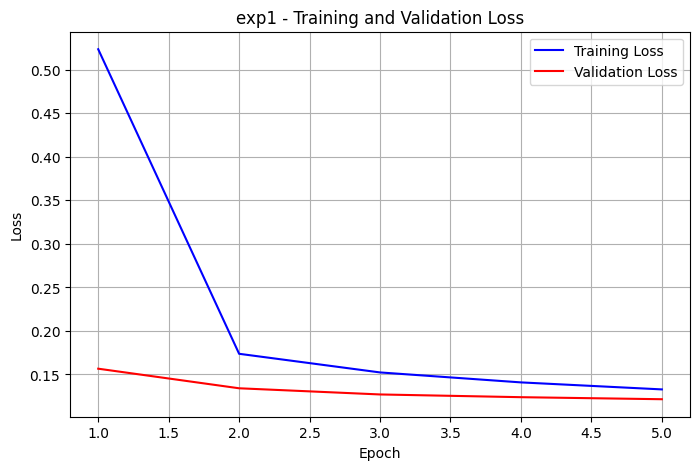

exp1 - Model saved to experiments/exp1

=== exp1 Evaluation ===
exp1 - Calculating BLEU scores for 308 test samples...
exp1 - Generating answer for: What is the recipe for Best Tuna Casserole?


I0000 00:00:1750559160.999727 2444717 service.cc:152] XLA service 0x415814d10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750559161.000211 2444717 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1750559161.260011 2444717 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


exp1 - Generated Answer: Best Tuna Casserole is This is my mom's recipe for the best tuna cranberry sauce I've ever had.. It ...

exp1 - Sample 1:
  Q: What is the recipe for Best Tuna Casserole?
  Expected: Best Tuna Casserole is This is a tuna casserole that even my picky family loves! The potato chips gi...
  Generated: Best Tuna Casserole is This is my mom's recipe for the best tuna cranberry sauce I've ever had.. It ...
  Raw: Best Tuna Casserole is This is my mom's recipe for the best tuna cranberry sauce I've ever had.. It ...
  BLEU: 0.0048
  Factual Errors: []
exp1 - Generating answer for: How long does it take to prepare Spicy Thai Basil Chicken (Pad Krapow Gai)?
exp1 - Generated Answer: Spicy Thai Basil Chicken (Pad Krapow Gai) takes 10 mins to prepare, nan to cook, for a total time of...

exp1 - Sample 2:
  Q: How long does it take to prepare Spicy Thai Basil Chicken (Pad Krapow Gai)?
  Expected: Spicy Thai Basil Chicken (Pad Krapow Gai) takes 15 mins to prepare, 10 mins to

In [13]:
exp_id = 'exp1'
config = EXPERIMENTS[exp_id]
print(f'\n=== Starting {exp_id}: {config["experiment_name"]} ===')
try:
    # Prepare data
    train_df, val_df, test_df = prepare_data(exp_id)

    # Train model
    model, tokenizer, train_loss, val_loss, training_time, history = train_model(config, train_df, val_df, exp_id)

    # Evaluate model
    avg_bleu, recipe_bleu, non_english_errors, factual_errors, eval_df, model, tokenizer = evaluate_model(model, tokenizer, config, test_df, exp_id)

    # Calculate composite score
    non_english_rate = non_english_errors / len(test_df)
    factual_error_rate = factual_errors / len(test_df)
    score = 0.6 * recipe_bleu + 0.2 * (1 - non_english_rate) + 0.2 * (1 - factual_error_rate)

    result = {
        'experiment_id': exp_id,
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'training_time': str(training_time),
        'avg_bleu': float(avg_bleu),
        'recipe_bleu': float(recipe_bleu),
        'non_english_errors': non_english_errors,
        'factual_errors': factual_errors,
        'score': float(score),
        'timestamp': datetime.now().isoformat()
    }
    results.append(result)

    print(f'{exp_id} - Composite Score: {score:.4f}')
    if score > best_score:
        best_score = score
        best_exp_id = exp_id
        best_model = model
        best_tokenizer = tokenizer

    with open(results_log, 'w') as f:
        json.dump(results, f, indent=2)
    print(f'{exp_id} - Results saved to {results_log}')

except Exception as e:
    print(f'{exp_id} - Failed: {str(e)}')
    with open(generation_error_log, 'a') as f:
        f.write(f'{datetime.now().isoformat()} - {exp_id} - Experiment Failed: {str(e)}\n')


## 14. Experiment 2: Data Augmentation

**Objective**: Introduce data augmentation by paraphrasing questions to increase dataset diversity and improve model generalization.

**Configuration**:
- Model: `t5-base`
- Input Length: 128
- Batch Size: 8
- Learning Rate: 1e-4
- Epochs: 5
- Temperature: 0.1
- Num Beams: 10
- Data Augmentation: Paraphrase questions (e.g., 'How many calories' -> 'What is the calorie count')
- Calorie Filter: Max 500 calories

**Expected Outcome**: Improved robustness to varied question phrasings, potentially higher recipe BLEU scores, but increased training time due to larger input length.

**Utility Functions Used**: `prepare_data`, `paraphrase_question`, `train_model`, `evaluate_model`.


=== Starting exp2: exp2_data_augmentation ===
exp2 - Loading dataset...
exp2 - Dataset loaded successfully. Total recipes: 344
exp2 - Total QA pairs after filtering: 4009
exp2 - Splits completed:
  Train: 3207 samples
  Validation: 401 samples
  Test: 401 samples

=== exp2 Training ===
exp2 - Training Configuration:
  model_name: t5-base
  max_input_length: 128
  max_target_length: 256
  batch_size: 8
  learning_rate: 0.0001
  num_epochs: 5
  warmup_steps: 20
  weight_decay: 0.02
  temperature: 0.1
  num_beams: 10
  experiment_name: exp2_data_augmentation
exp2 - Loading t5-base...


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


exp2 - Model and tokenizer loaded successfully.
exp2 - Preprocessing data...
exp2 - Preprocessing completed. Input shapes: (3207, 128)
exp2 - Preprocessing data...
exp2 - Preprocessing completed. Input shapes: (401, 128)
exp2 - Starting training...
Epoch 1/5
401/401 [==============================] - 2322s 6s/step - loss: 0.4180 - val_loss: 0.1266
Epoch 2/5
401/401 [==============================] - 2354s 6s/step - loss: 0.1427 - val_loss: 0.1091
Epoch 3/5
401/401 [==============================] - 2313s 6s/step - loss: 0.1251 - val_loss: 0.1027
Epoch 4/5
401/401 [==============================] - 2307s 6s/step - loss: 0.1164 - val_loss: 0.0998
Epoch 5/5
401/401 [==============================] - 2297s 6s/step - loss: 0.1095 - val_loss: 0.0978

exp2 - Training Results:
  Final Train Loss: 0.1095
  Final Val Loss: 0.0978
  Training Time: 3:13:13.496855


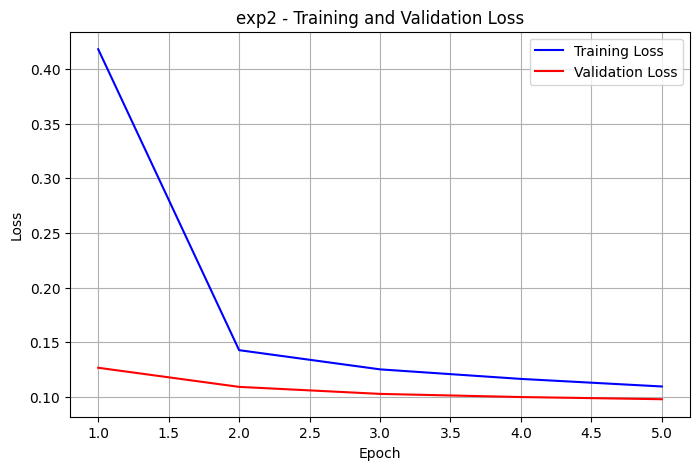

exp2 - Model saved to experiments/exp2

=== exp2 Evaluation ===
exp2 - Calculating BLEU scores for 401 test samples...
exp2 - Generating answer for: How many servings does Stacey's Hamburger Seasoning make?
exp2 - Generated Answer: Stacey's Hamburger Seasoning makes 4 servings....

exp2 - Sample 1:
  Q: How many servings does Stacey's Hamburger Seasoning make?
  Expected: Stacey's Hamburger Seasoning makes 8 servings....
  Generated: Stacey's Hamburger Seasoning makes 4 servings....
  Raw: Stacey's Hamburger Seasoning makes 4 servings....
  BLEU: 0.5946
  Factual Errors: []
exp2 - Generating answer for: What ingredients are needed for Easy Lasagna II?
exp2 - Generated Answer: The ingredients for Easy Lasagna II are: 1 cup all-purpose flour 1 teaspoon baking powder teaspoon s...

exp2 - Sample 2:
  Q: What ingredients are needed for Easy Lasagna II?
  Expected: The ingredients for Easy Lasagna II are: 1 pound lean ground beef 1 (32 ounce) jar spaghetti sauce 3...
  Generated: The ingred

In [14]:
exp_id = 'exp2'
config = EXPERIMENTS[exp_id]
print(f'\n=== Starting {exp_id}: {config["experiment_name"]} ===')
try:
    # Prepare data
    train_df, val_df, test_df = prepare_data(exp_id)

    # Train model
    model, tokenizer, train_loss, val_loss, training_time, history = train_model(config, train_df, val_df, exp_id)

    # Evaluate model
    avg_bleu, recipe_bleu, non_english_errors, factual_errors, eval_df, model, tokenizer = evaluate_model(model, tokenizer, config, test_df, exp_id)

    # Calculate composite score
    non_english_rate = non_english_errors / len(test_df)
    factual_error_rate = factual_errors / len(test_df)
    score = 0.6 * recipe_bleu + 0.2 * (1 - non_english_rate) + 0.2 * (1 - factual_error_rate)

    result = {
        'experiment_id': exp_id,
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'training_time': str(training_time),
        'avg_bleu': float(avg_bleu),
        'recipe_bleu': float(recipe_bleu),
        'non_english_errors': non_english_errors,
        'factual_errors': factual_errors,
        'score': float(score),
        'timestamp': datetime.now().isoformat()
    }
    results.append(result)

    print(f'{exp_id} - Composite Score: {score:.4f}')
    if score > best_score:
        best_score = score
        best_exp_id = exp_id
        best_model = model
        best_tokenizer = tokenizer

    with open(results_log, 'w') as f:
        json.dump(results, f, indent=2)
    print(f'{exp_id} - Results saved to {results_log}')

except Exception as e:
    print(f'{exp_id} - Failed: {str(e)}')
    with open(generation_error_log, 'a') as f:
        f.write(f'{datetime.now().isoformat()} - {exp_id} - Experiment Failed: {str(e)}\n')


## 15. Experiment 3: Hyperparameter Tuning

**Objective**: Tune hyperparameters (batch size, learning rate, epochs) to optimize model convergence and performance.

**Configuration**:
- Model: `t5-base`
- Input Length: 128
- Batch Size: 4 (smaller for finer gradient updates)
- Learning Rate: 3e-4 (higher for faster convergence)
- Epochs: 5
- Gradient Clip Norm: 1.0 (to prevent exploding gradients)
- Temperature: 0.1
- Num Beams: 10
- Early Stopping: Enabled

**Expected Outcome**: Potentially lower loss and higher BLEU scores due to optimized training, but longer training time due to more epochs and smaller batch size.

**Utility Functions Used**: `prepare_data`, `train_model`, `evaluate_model`.


=== Starting exp3: exp3_hyperparameter_tuning ===
exp3 - Loading dataset...
exp3 - Dataset loaded successfully. Total recipes: 344
exp3 - Total QA pairs after filtering: 3074
exp3 - Splits completed:
  Train: 2459 samples
  Validation: 307 samples
  Test: 308 samples

=== exp3 Training ===
exp3 - Training Configuration:
  model_name: t5-base
  max_input_length: 128
  max_target_length: 256
  batch_size: 4
  learning_rate: 0.0003
  num_epochs: 5
  warmup_steps: 20
  weight_decay: 0.02
  gradient_clip_norm: 1.0
  temperature: 0.1
  num_beams: 10
  experiment_name: exp3_hyperparameter_tuning
exp3 - Loading t5-base...


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


exp3 - Model and tokenizer loaded successfully.
exp3 - Preprocessing data...
exp3 - Preprocessing completed. Input shapes: (2459, 128)
exp3 - Preprocessing data...
exp3 - Preprocessing completed. Input shapes: (307, 128)
exp3 - Starting training...
Epoch 1/5
615/615 [==============================] - 1949s 3s/step - loss: 0.2651 - val_loss: 0.1312
Epoch 2/5
615/615 [==============================] - 1860s 3s/step - loss: 0.1390 - val_loss: 0.1253
Epoch 3/5
615/615 [==============================] - 1859s 3s/step - loss: 0.1218 - val_loss: 0.1228
Epoch 4/5
615/615 [==============================] - 1909s 3s/step - loss: 0.1091 - val_loss: 0.1248
Epoch 5/5
615/615 [==============================] - 1923s 3s/step - loss: 0.0977 - val_loss: 0.1268

exp3 - Training Results:
  Final Train Loss: 0.0977
  Final Val Loss: 0.1268
  Training Time: 2:38:20.461921


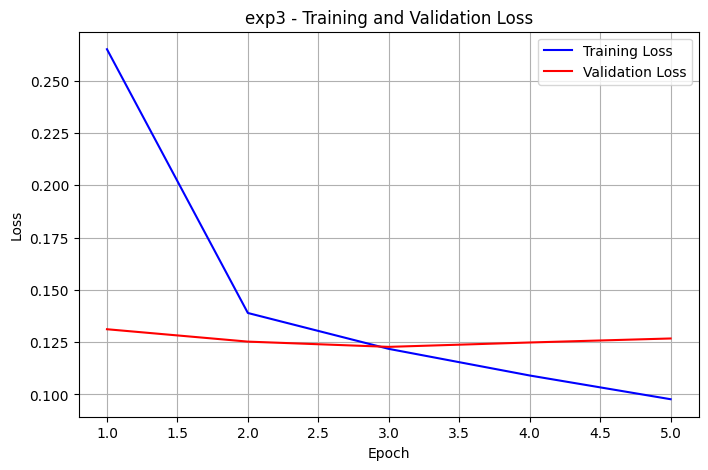

exp3 - Model saved to experiments/exp3

=== exp3 Evaluation ===
exp3 - Calculating BLEU scores for 308 test samples...
exp3 - Generating answer for: What is the recipe for Best Tuna Casserole?
exp3 - Generated Answer: Best Tuna Casserole is This is a great recipe for tuna casserole.. It requires 1 (8 ounce) can tuna,...

exp3 - Sample 1:
  Q: What is the recipe for Best Tuna Casserole?
  Expected: Best Tuna Casserole is This is a tuna casserole that even my picky family loves! The potato chips gi...
  Generated: Best Tuna Casserole is This is a great recipe for tuna casserole.. It requires 1 (8 ounce) can tuna,...
  Raw: Best Tuna Casserole is This is a great recipe for tuna casserole.. It requires 1 (8 ounce) can tuna,...
  BLEU: 0.0102
  Factual Errors: []
exp3 - Generating answer for: How long does it take to prepare Spicy Thai Basil Chicken (Pad Krapow Gai)?
exp3 - Generated Answer: Spicy Thai Basil Chicken (Pad Krapow Gai) takes 10 mins to prepare, nan to cook, for a total time of

In [15]:
exp_id = 'exp3'
config = EXPERIMENTS[exp_id]
print(f'\n=== Starting {exp_id}: {config["experiment_name"]} ===')
try:
    # Prepare data
    train_df, val_df, test_df = prepare_data(exp_id)

    # Train model
    model, tokenizer, train_loss, val_loss, training_time, history = train_model(config, train_df, val_df, exp_id)

    # Evaluate model
    avg_bleu, recipe_bleu, non_english_errors, factual_errors, eval_df, model, tokenizer = evaluate_model(model, tokenizer, config, test_df, exp_id)

    # Calculate composite score
    non_english_rate = non_english_errors / len(test_df)
    factual_error_rate = factual_errors / len(test_df)
    score = 0.6 * recipe_bleu + 0.2 * (1 - non_english_rate) + 0.2 * (1 - factual_error_rate)

    result = {
        'experiment_id': exp_id,
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'training_time': str(training_time),
        'avg_bleu': float(avg_bleu),
        'recipe_bleu': float(recipe_bleu),
        'non_english_errors': non_english_errors,
        'factual_errors': factual_errors,
        'score': float(score),
        'timestamp': datetime.now().isoformat()
    }
    results.append(result)

    print(f'{exp_id} - Composite Score: {score:.4f}')
    if score > best_score:
        best_score = score
        best_exp_id = exp_id
        best_model = model
        best_tokenizer = tokenizer

    with open(results_log, 'w') as f:
        json.dump(results, f, indent=2)
    print(f'{exp_id} - Results saved to {results_log}')

except Exception as e:
    print(f'{exp_id} - Failed: {str(e)}')
    with open(generation_error_log, 'a') as f:
        f.write(f'{datetime.now().isoformat()} - {exp_id} - Experiment Failed: {str(e)}\n')


## 16. Experiment 4: Hybrid Approach

**Objective**: Combine strict data filtering (like exp2) with optimized hyperparameters and generation settings to balance quality and robustness.

**Configuration**:
- Model: `t5-base`
- Input Length: 128
- Batch Size: 6 (balanced)
- Learning Rate: 2e-4 (moderate)
- Epochs: 5
- Gradient Clip Norm: 1.0
- Temperature: 0.05 (low for precision)
- Num Beams: 12 (high for quality)
- Calorie Filter: Max 500 calories
- Dish-Specific Calorie Ranges: Enabled (e.g., soup: 20-200, salad: 50-300)
- Early Stopping: Enabled

**Expected Outcome**: Best balance of BLEU scores, low factual errors, and reasonable training time, potentially achieving the highest composite score.

**Utility Functions Used**: `prepare_data`, `train_model`, `evaluate_model`.


=== Starting exp4: exp4_hybrid ===
exp4 - Loading dataset...
exp4 - Dataset loaded successfully. Total recipes: 344
exp4 - Total QA pairs after filtering: 3027
exp4 - Splits completed:
  Train: 2421 samples
  Validation: 303 samples
  Test: 303 samples

=== exp4 Training ===
exp4 - Training Configuration:
  model_name: t5-base
  max_input_length: 128
  max_target_length: 256
  batch_size: 6
  learning_rate: 0.0002
  num_epochs: 5
  warmup_steps: 20
  weight_decay: 0.02
  gradient_clip_norm: 1.0
  temperature: 0.05
  num_beams: 12
  experiment_name: exp4_hybrid
exp4 - Loading t5-base...


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


exp4 - Model and tokenizer loaded successfully.
exp4 - Preprocessing data...
exp4 - Preprocessing completed. Input shapes: (2421, 128)
exp4 - Preprocessing data...
exp4 - Preprocessing completed. Input shapes: (303, 128)
exp4 - Starting training...
Epoch 1/5
404/404 [==============================] - 1808s 4s/step - loss: 0.3500 - val_loss: 0.1473
Epoch 2/5
404/404 [==============================] - 1862s 5s/step - loss: 0.1514 - val_loss: 0.1364
Epoch 3/5
404/404 [==============================] - 1776s 4s/step - loss: 0.1352 - val_loss: 0.1331
Epoch 4/5
404/404 [==============================] - 1862s 5s/step - loss: 0.1234 - val_loss: 0.1321
Epoch 5/5
404/404 [==============================] - 1815s 4s/step - loss: 0.1132 - val_loss: 0.1317

exp4 - Training Results:
  Final Train Loss: 0.1132
  Final Val Loss: 0.1317
  Training Time: 2:32:03.890780


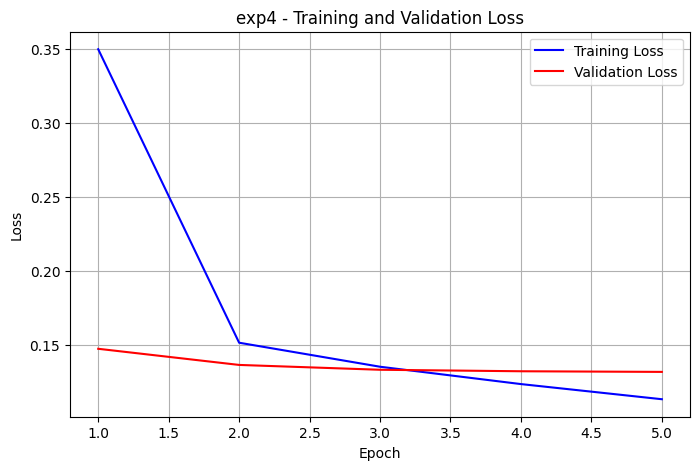

exp4 - Model saved to experiments/exp4

=== exp4 Evaluation ===
exp4 - Calculating BLEU scores for 303 test samples...
exp4 - Generating answer for: What is the recipe for Chicken Marsala?
exp4 - Generated Answer: Chicken Marsala is This is a very simple recipe that I came up with a few years ago. It is very easy...

exp4 - Sample 1:
  Q: What is the recipe for Chicken Marsala?
  Expected: Chicken Marsala is A delicious, classic chicken dish -- lightly coated chicken breasts braised with ...
  Generated: Chicken Marsala is This is a very simple recipe that I came up with a few years ago. It is very easy...
  Raw: Chicken Marsala is This is a very simple recipe that I came up with a few years ago. It is very easy...
  BLEU: 0.0007
  Factual Errors: []
exp4 - Generating answer for: How long does it take to prepare Basic Chicken Salad?
exp4 - Generated Answer: Basic Chicken Salad takes 10 mins to prepare, nan to cook, for a total time of 15 mins....

exp4 - Sample 2:
  Q: How long does it

In [16]:
exp_id = 'exp4'
config = EXPERIMENTS[exp_id]
print(f'\n=== Starting {exp_id}: {config["experiment_name"]} ===')
try:
    # Prepare data
    train_df, val_df, test_df = prepare_data(exp_id)

    # Train model
    model, tokenizer, train_loss, val_loss, training_time, history = train_model(config, train_df, val_df, exp_id)

    # Evaluate model
    avg_bleu, recipe_bleu, non_english_errors, factual_errors, eval_df, model, tokenizer = evaluate_model(model, tokenizer, config, test_df, exp_id)

    # Calculate composite score
    non_english_rate = non_english_errors / len(test_df)
    factual_error_rate = factual_errors / len(test_df)
    score = 0.6 * recipe_bleu + 0.2 * (1 - non_english_rate) + 0.2 * (1 - factual_error_rate)

    result = {
        'experiment_id': exp_id,
        'train_loss': float(train_loss),
        'val_loss': float(val_loss),
        'training_time': str(training_time),
        'avg_bleu': float(avg_bleu),
        'recipe_bleu': float(recipe_bleu),
        'non_english_errors': non_english_errors,
        'factual_errors': factual_errors,
        'score': float(score),
        'timestamp': datetime.now().isoformat()
    }
    results.append(result)

    print(f'{exp_id} - Composite Score: {score:.4f}')
    if score > best_score:
        best_score = score
        best_exp_id = exp_id
        best_model = model
        best_tokenizer = tokenizer

    with open(results_log, 'w') as f:
        json.dump(results, f, indent=2)
    print(f'{exp_id} - Results saved to {results_log}')

except Exception as e:
    print(f'{exp_id} - Failed: {str(e)}')
    with open(generation_error_log, 'a') as f:
        f.write(f'{datetime.now().isoformat()} - {exp_id} - Experiment Failed: {str(e)}\n')


## 17. Experiment Comparison

Compare the performance of all experiments using BLEU scores, error counts, and composite scores. Visualize the results to identify the best experiment.


Best model from exp2 saved to best_recipe_chatbot with score 0.6698


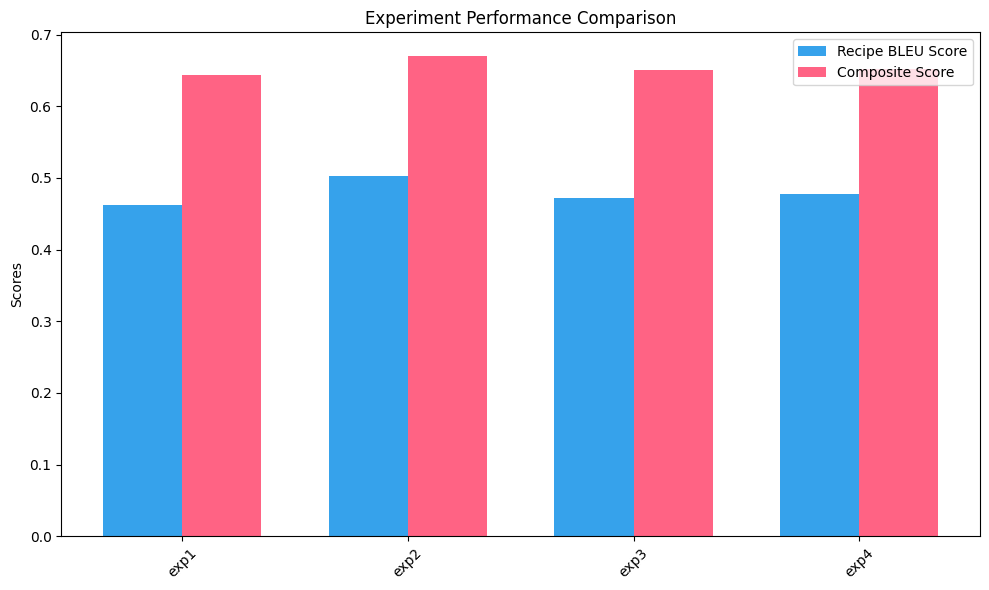

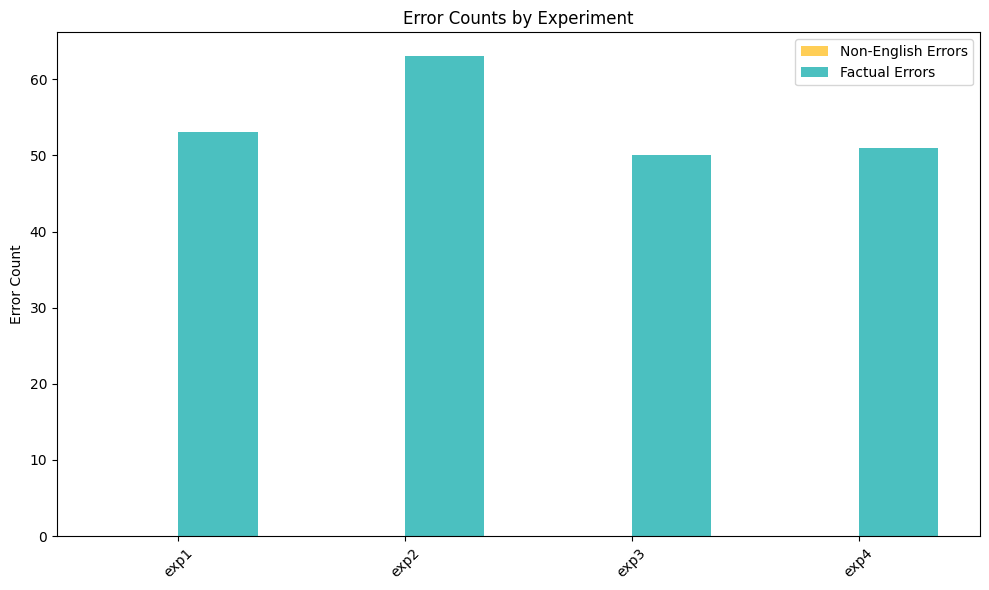


Experiment Comparison Summary:
experiment_id  recipe_bleu  non_english_errors  factual_errors    score  training_time
         exp1     0.462470                   0              53 0.643066 2:28:06.235153
         exp2     0.502082                   0              63 0.669828 3:13:13.496855
         exp3     0.471917                   0              50 0.650682 2:38:20.461921
         exp4     0.477426                   0              51 0.652792 2:32:03.890780

Best Experiment: exp2 with Composite Score: 0.6698


In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === 1. Save the best model and tokenizer ===
if best_model and best_tokenizer:
    best_save_path = 'best_recipe_chatbot'
    os.makedirs(best_save_path, exist_ok=True)
    best_model.save_pretrained(best_save_path)
    best_tokenizer.save_pretrained(best_save_path)
    print(f'\nBest model from {best_exp_id} saved to {best_save_path} with score {best_score:.4f}')


# === 2. Prepare data for visualization ===
exp_ids = [r['experiment_id'] for r in results]
recipe_bleu_scores = [r['recipe_bleu'] for r in results]
non_english_errors = [r['non_english_errors'] for r in results]
factual_errors = [r['factual_errors'] for r in results]
composite_scores = [r['score'] for r in results]


# === 3. Plot: Recipe BLEU Score vs Composite Score ===
x = np.arange(len(exp_ids))
width = 0.35

fig1, ax1 = plt.subplots(figsize=(10, 6))
bars1 = ax1.bar(x - width/2, recipe_bleu_scores, width, label='Recipe BLEU Score', color='#36A2EB')
bars2 = ax1.bar(x + width/2, composite_scores, width, label='Composite Score', color='#FF6384')

ax1.set_ylabel('Scores')
ax1.set_title('Experiment Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(exp_ids, rotation=45)
ax1.legend()
plt.tight_layout()
plt.show()


# === 4. Plot: Non-English Errors vs Factual Errors ===
fig2, ax2 = plt.subplots(figsize=(10, 6))
bars3 = ax2.bar(x - width/2, non_english_errors, width, label='Non-English Errors', color='#FFCE56')
bars4 = ax2.bar(x + width/2, factual_errors, width, label='Factual Errors', color='#4BC0C0')

ax2.set_ylabel('Error Count')
ax2.set_title('Error Counts by Experiment')
ax2.set_xticks(x)
ax2.set_xticklabels(exp_ids, rotation=45)
ax2.legend()
plt.tight_layout()
plt.show()


# === 5. Save and display summary table ===
results_df = pd.DataFrame(results)
results_df = results_df[['experiment_id', 'recipe_bleu', 'non_english_errors', 'factual_errors', 'score', 'training_time']]
os.makedirs('experiments', exist_ok=True)
results_df.to_csv('experiments/comparison.csv', index=False)

print('\nExperiment Comparison Summary:')
print(results_df.to_string(index=False))
print(f'\nBest Experiment: {best_exp_id} with Composite Score: {best_score:.4f}')


## 18. Interactive Testing with Best Model

Test the best-performing model interactively by inputting recipe-related questions. The model generates answers, and factual errors are checked. This cell demonstrates real-world usability.

**Utility Functions Used**: `generate_answer_optimized`, `check_factual_errors`.

In [19]:
if best_model and best_tokenizer:
    config = EXPERIMENTS[best_exp_id]
    print(f'\n=== Interactive Testing with Best Model ({best_exp_id}) ===')
    print('Type a recipe-related question (e.g., "How many calories in Miso Soup?") or "exit" to quit.')

    while True:
        question = input('Enter your question: ').strip()
        if question.lower() == 'exit':
            print('Exiting interactive testing.')
            break
        if not question:
            print('Please enter a valid question.')
            continue

        start_time = time.time()
        answer, raw_answer = generate_answer_optimized(question, best_model, best_tokenizer, config, best_exp_id)
        factual_errors = check_factual_errors(answer, question, experiment_id=best_exp_id)
        elapsed_time = time.time() - start_time

        print(f'\nQuestion: {question}')
        print(f'Answer: {answer}')
        print(f'Raw Answer: {raw_answer if raw_answer else "None"}')
        print(f'Factual Errors: {factual_errors}')
        print(f'Response Time: {elapsed_time:.2f} seconds\n')
else:
    print('No best model available for testing.')



=== Interactive Testing with Best Model (exp2) ===
Type a recipe-related question (e.g., "How many calories in Miso Soup?") or "exit" to quit.
exp2 - Generating answer for: How many calories in Miso Soup?
exp2 - Generated Answer: Miso Soup has 187.8 calories per serving....

Question: How many calories in Miso Soup?
Answer: Miso Soup has 187.8 calories per serving.
Raw Answer: Miso Soup has 187.8 calories per serving.
Factual Errors: []
Response Time: 1.97 seconds

exp2 - Generating answer for: What is the recipe for Gourmet Mushroom Risotto?
exp2 - Generated Answer: Gourmet Mushroom Risotto is This is a great way to start a meal.. It requires 1 tablespoon olive oil...

Question: What is the recipe for Gourmet Mushroom Risotto?
Answer: Gourmet Mushroom Risotto is This is a great way to start a meal.. It requires 1 tablespoon olive oil 2 tablespoons olive oil 1 teaspoon garlic powder 1 teaspoon ground black pepper teaspoon ground cayenne pepper.
Raw Answer: Gourmet Mushroom Risotto is 